<a href="https://colab.research.google.com/github/kimhwijin/HandsOnMachineLearing/blob/main/HOML_Exercise_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons

In [31]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow_addons as tfa

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

#8.

# Grammer_StringGenerater

In [3]:
#문법에 맞는 문자열을 반환하는 함수

#문법, LR table 과 비슷함
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    #마지막
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    #마지막
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output=[]
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        #다음 문자와 상태
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

In [4]:
for _ in range(25):
    #25개의 문자열 생성
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

#Wrong_StringGenrater

In [5]:
#모든 가능한 알파벳들
POSSIBLE_CHARS = "BEPSTVX"

#잘못된 문자열 만들기
def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    #올바른 문자열에
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    #있을수는 있지만 올바른 문자열엔 없는 문자열을
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    #중간에 하나 추가함
    return good_string[:index] + bad_char + good_string[index + 1:]

In [6]:
#잘못된 문자열
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPVVETV BTBTSSSPXXVVETE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE BPBPVVEPT BTBPTVEETE BTBTSSXXTTVXETE BTBTSXTTVVETE BPBPVVTPE BTBTSXTTVVETE EPBPVPXVVEPE BPTTXSEPE BPBTXXSPXTVVEPE BTBTXSPTE BPTTSXXTVPXVVEPE PPBPVPSEPE 

#Char_To_Int

In [7]:
#문자열을 숫자로 바꾸기, 문자의 인덱스 리스트로 변경한다.
def strings_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]

#DataGenerater

In [8]:
#올바른 문자열, 잘못된 문자열 1 : 1 인 샘플과 레이블 생성
def generate_dataset(size):
    good_strings = [strings_to_ids(generate_string(embedded_reber_grammar)) for _ in range(size // 2)]
    bad_strings = [strings_to_ids(generate_corrupted_string(embedded_reber_grammar)) for _ in range(size // 2)]
    all_strings = good_strings + bad_strings
    #ragged 텐서 생성
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] + [[0.] for _ in range(len(bad_strings))])
    return X, y


#Generate_Data

In [76]:
X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)
X_test, y_test = generate_dataset(2000)

In [10]:
print(X_train[0])
s = ''
for i in X_train[0]:
    s += POSSIBLE_CHARS[i]
print(s, y_train[0][0])

tf.Tensor([0 4 0 2 5 5 1 4 1], shape=(9,), dtype=int32)
BTBPVVETE 1.0


#Binary_Sequence_Classifier

In [ ]:
embedding_size = 5

model = keras.models.Sequential([
    #인풋데이터는 ragged tensor, int32 타입
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation='sigmoid')
])

#네스테로프 가속 경사하강법 
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.95, nesterov=True)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#Model_Train

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/gru/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/gru/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/gru/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


313/313 [==============================] - 20s 55ms/step - loss: 0.6910 - accuracy: 0.5093 - val_loss: 0.6825 - val_accuracy: 0.5595
Epoch 2/20
313/313 [==============================] - 17s 55ms/step - loss: 0.6678 - accuracy: 0.5720 - val_loss: 0.6706 - val_accuracy: 0.5975
Epoch 3/20
313/313 [==============================] - 17s 55ms/step - loss: 0.6505 - accuracy: 0.5796 - val_loss: 0.6472 - val_accuracy: 0.6135
Epoch 4/20
313/313 [==============================] - 17s 56ms/step - loss: 0.6356 - accuracy: 0.5963 - val_loss: 0.6239 - val_accuracy: 0.6290
Epoch 5/20
313/313 [==============================] - 18s 56ms/step - loss: 0.6059 - accuracy: 0.6342 - val_loss: 0.5778 - val_accuracy: 0.7010
Epoch 6/20
313/313 [==============================] - 17s 56ms/step - loss: 0.5474 - accuracy: 0.7015 - val_loss: 0.5608 - val_accuracy: 0.5500
Epoch 7/20
313/313 [==============================] - 17s 55ms/step - loss: 0.3947 - accuracy: 0.8246 - val_loss: 0.2995 - val_accuracy: 0.8870
Epo

#Model_Evaluate

In [ ]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 1s 9ms/step - loss: 6.7382e-04 - accuracy: 1.0000


[0.0006738215452060103, 1.0]

#9.

#9-1

#Random_Date_Genrater

In [11]:
from datetime import date

#January 22, 2019 -> 2019-01-22 형식으로
MONTHS = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    #숫자
    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    #month, day, year 을 빼내기위해서
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    #샘플
    X = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    #타깃 YYYY-mm-dd 형식으로 변환
    y = [dt.isoformat() for dt in dates]
    
    return X, y

In [12]:
n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
July 22, 1344            1344-07-22               
March 21, 7185           7185-03-21               
January 02, 5192         5192-01-02               


#INPUT_OUTPUT_CHARS

In [13]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
OUTPUT_CHARS = "0123456789-"
INPUT_CHARS, OUTPUT_CHARS

(' ,0123456789ADFJMNOSabceghilmnoprstuvy', '0123456789-')

#Input_Output_Tokenizer

In [14]:
input_chars = MONTHS + ['0123456789, ']
output_chars = ['0123456789-']

input_tokenizer = keras.preprocessing.text.Tokenizer(lower=False, char_level=True)
input_tokenizer.fit_on_texts(sorted(set(input_chars)))
input_vocab_size = len(input_tokenizer.word_index)

output_tokenizer = keras.preprocessing.text.Tokenizer(lower=False, char_level=True)
output_tokenizer.fit_on_texts(sorted(set(output_chars)))
output_vocab_size = len(output_tokenizer.word_index)

In [15]:
print(input_tokenizer.word_index)
print(output_tokenizer.word_index)

{'e': 1, 'r': 2, 'u': 3, 'b': 4, 'a': 5, 'y': 6, 't': 7, 'c': 8, 'm': 9, 'J': 10, 'A': 11, 'p': 12, 'l': 13, 'n': 14, 'M': 15, 'o': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ',': 27, ' ': 28, 'i': 29, 'g': 30, 's': 31, 'D': 32, 'F': 33, 'h': 34, 'N': 35, 'v': 36, 'O': 37, 'S': 38}
{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, '-': 11}


In [ ]:
X, y = random_dates(3)

print('-'*25)
print(X[0])
X = input_tokenizer.texts_to_sequences(X)
print(X[0])
X = input_tokenizer.sequences_to_texts(X)
print(X[0][::2])

print('-'*25)

print(y[0])
y = output_tokenizer.texts_to_sequences(y)
print(y[0])
y = output_tokenizer.sequences_to_texts(y)
print(y[0][::2])


-------------------------
April 09, 3947
[11, 12, 2, 29, 13, 28, 17, 26, 27, 28, 20, 26, 21, 24]
April 09, 3947
-------------------------
3947-04-09
[4, 10, 5, 8, 11, 1, 5, 11, 1, 10]
3947-04-09


#Dataset_Generater

In [16]:
def prepare_date_strs(date_strs, tokenizer):
    ids = [dt for dt in tokenizer.texts_to_sequences(date_strs)]
    X = tf.ragged.constant(ids, ragged_rank=1)
    return X.to_tensor() #ragged 텐서를 기본 텐서로 부족한 부분은 0 패딩토큰으로 채운다.

def create_dataset(n_dates):
    X, Y = random_dates(n_dates)
    return prepare_date_strs(X, input_tokenizer), prepare_date_strs(Y, output_tokenizer)

In [77]:
X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [18]:
print(X_train[0], Y_train[0], sep='\n')
print(input_tokenizer.sequences_to_texts([X_train[0].numpy()])[0][::2])
print(output_tokenizer.sequences_to_texts([Y_train[0].numpy()])[0][::2])

tf.Tensor([11 12  2 29 13 28 17 26 27 28 20 26 21 24  0  0  0  0], shape=(18,), dtype=int32)
tf.Tensor([ 4 10  5  8 11  1  5 11  1 10], shape=(10,), dtype=int32)
April 09, 3947
3947-04-09


#Seq2Seq_Model

In [20]:
embedding_size = 32
#출력 최대 길이 : 10 (yyyy-mm-dd)
max_output_length = Y_train.shape[-1]

#인코더 디코더 구조를 사용한다.

#인코더, 시퀀스 투 벡터 구조
encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=input_vocab_size + 1, output_dim=embedding_size, input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(output_vocab_size + 1, activation='softmax')
])

model = keras.models.Sequential([
    encoder,
    #출력길이가 10이니깐 인코더 출력을 10번 반복해서, 디코더가 10개의 출력을 만들도록함
    keras.layers.RepeatVector(max_output_length),
    decoder
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128)               83680     
                                                                 
 repeat_vector (RepeatVector  (None, 10, 128)          0         
 )                                                               
                                                                 
 sequential_1 (Sequential)   (None, 10, 12)            133132    
                                                                 
Total params: 216,812
Trainable params: 216,812
Non-trainable params: 0
_________________________________________________________________


In [21]:
optimizer = keras.optimizers.Nadam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [22]:
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 10s 11ms/step - loss: 1.7915 - accuracy: 0.3509 - val_loss: 1.3838 - val_accuracy: 0.4813
Epoch 2/20
313/313 [==============================] - 3s 8ms/step - loss: 1.6229 - accuracy: 0.4306 - val_loss: 1.2769 - val_accuracy: 0.5559
Epoch 3/20
313/313 [==============================] - 3s 8ms/step - loss: 1.1316 - accuracy: 0.6030 - val_loss: 0.9796 - val_accuracy: 0.6527
Epoch 4/20
313/313 [==============================] - 3s 8ms/step - loss: 0.9460 - accuracy: 0.6666 - val_loss: 0.7504 - val_accuracy: 0.7247
Epoch 5/20
313/313 [==============================] - 3s 8ms/step - loss: 0.6254 - accuracy: 0.7651 - val_loss: 0.5397 - val_accuracy: 0.7903
Epoch 6/20
313/313 [==============================] - 3s 8ms/step - loss: 0.7077 - accuracy: 0.7503 - val_loss: 0.4770 - val_accuracy: 0.8150
Epoch 7/20
313/313 [==============================] - 3s 8ms/step - loss: 0.3763 - accuracy: 0.8550 - val_loss: 0.5772 - val_accuracy: 0.7980
Epoc

In [23]:
model.evaluate(X_test,Y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 1.0000


[0.0014783494407311082, 1.0]

#Model_Return_To_Strings

In [24]:
def ids_to_strings(ids, tokenizer):
    return tokenizer.sequences_to_texts(ids)

print('-'*25)
#X_new = X_test[:3]
#패딩이 없는 데이터셋이라 잘 예측을 못함
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"], input_tokenizer)
X_samples = ids_to_strings(X_new.numpy(), input_tokenizer)
print(*[x_sample[::2] for x_sample in X_samples], sep='\n')


print('-'*25)
Y_new = np.argmax(model.predict(X_new), axis=-1)
Y_new = ids_to_strings(Y_new, output_tokenizer)
print(*[y_sample[::2] for y_sample in Y_new], sep='\n')

-------------------------
May 02, 2020
July 14, 1789
-------------------------
2020-01-02
1789-01-14


In [25]:
max_input_length = X_train.shape[1]

def prepare_date_strs_with_padded(date_strs, tokenizer):
    X = prepare_date_strs(date_strs, tokenizer)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, paddings=[[0,0], [0, max_input_length - X.shape[1]]])
    return X


print('-'*25)
#패딩추가, 잘예측함
X_new = prepare_date_strs_with_padded(["May 02, 2020", "July 14, 1789"], input_tokenizer)
X_samples = ids_to_strings(X_new.numpy(), input_tokenizer)
print(*[x_sample[::2] for x_sample in X_samples], sep='\n')


print('-'*25)
Y_new = np.argmax(model.predict(X_new), axis=-1)
Y_new = ids_to_strings(Y_new, output_tokenizer)
print(*[y_sample[::2] for y_sample in Y_new], sep='\n')

-------------------------
May 02, 2020
July 14, 1789
-------------------------
2020-05-02
1789-07-14


#9-2

#Decoder_Input_Target_Shift

In [78]:
sos_id = output_vocab_size + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

#타깃을 오른쪽으로 한번 shift 하고 맨앞에 sos 토큰을 추가한 디코더 입력
#원래는 인코더벡터를 복사해서 디코더에 입력했지만, 쉬프트된 타깃을 주입해서 이전타깃이 무엇인지 확인할수 있게한다.
X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

In [35]:
ids_to_strings(X_train_decoder[:5].numpy(), output_tokenizer)

['3 9 4 7 - 0 4 - 0',
 '7 6 9 2 - 0 5 - 0',
 '5 0 4 3 - 0 2 - 2',
 '5 7 1 7 - 0 5 - 0',
 '3 7 6 2 - 0 6 - 1']

#Model

In [ ]:
encoder_embedding_size = 32
decoder_embedding_size = 32

lstm_units = 128

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(input_dim=input_vocab_size+1, output_dim=encoder_embedding_size)(encoder_input)
#인코더의 출력벡터는 무시한다!!
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(output_vocab_size+1, decoder_embedding_size)(decoder_input)
#대신 인코더의 LSTM의 상태와 디코더의 LSTM과 연결시킨다.
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(output_vocab_size+1, activation='softmax')(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 32)     1248        ['input_2[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 32)     384         ['input_3[0][0]']                
                                                                                              

In [ ]:
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10, validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 7s 10ms/step - loss: 1.6702 - accuracy: 0.3712 - val_loss: 1.4184 - val_accuracy: 0.4505
Epoch 2/10
313/313 [==============================] - 3s 8ms/step - loss: 1.2351 - accuracy: 0.5254 - val_loss: 0.9711 - val_accuracy: 0.6467
Epoch 3/10
313/313 [==============================] - 3s 8ms/step - loss: 0.6865 - accuracy: 0.7556 - val_loss: 0.3986 - val_accuracy: 0.8838
Epoch 4/10
313/313 [==============================] - 3s 8ms/step - loss: 0.2499 - accuracy: 0.9391 - val_loss: 0.1254 - val_accuracy: 0.9822
Epoch 5/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0805 - accuracy: 0.9910 - val_loss: 0.0555 - val_accuracy: 0.9952
Epoch 6/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0637 - accuracy: 0.9913 - val_loss: 0.0268 - val_accuracy: 0.9991
Epoch 7/10
313/313 [==============================] - 3s 8ms/step - loss: 0.0192 - accuracy: 0.9998 - val_loss: 0.0159 - val_accuracy: 0.9998
Epoch

In [ ]:
print(ids_to_strings(np.argmax(model.predict([X_train[:5], X_train_decoder[:5]]), axis=-1), output_tokenizer))
print(ids_to_strings(Y_train[:5].numpy(), output_tokenizer))

['5 7 1 7 - 0 5 - 0 5', '3 7 6 2 - 0 6 - 1 3', '6 5 6 2 - 1 2 - 0 1', '3 9 8 7 - 0 3 - 0 4', '4 8 3 0 - 0 6 - 0 5']
['5 7 1 7 - 0 5 - 0 5', '3 7 6 2 - 0 6 - 1 3', '6 5 6 2 - 1 2 - 0 1', '3 9 8 7 - 0 3 - 0 4', '4 8 3 0 - 0 6 - 0 5']


In [ ]:
#X_new = output_tokenizer.texts_to_sequences(["1789-07-14", "2020-05-01"])

def predict_date_strs(date_strs):
    X = prepare_date_strs_with_padded(date_strs, input_tokenizer)
    #X = date_strs
    sos_id = output_vocab_size + 1
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)

    for index in range(max_output_length):
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, max_output_length-index]])
        Y_probas = tf.argmax(model.predict([X, X_decoder]), axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_probas[:, index:index+1]], axis=1)
    return ids_to_strings(Y_pred.numpy(), output_tokenizer)

print(predict_date_strs(["May 02, 2020", "July 14, 1789"]))

['2 0 2 0 - 0 5 - 0 2', '1 7 8 9 - 0 7 - 1 4']


#9-3

#Addon_Sampler_Model

In [ ]:

encoder_embedding_size = 32
decoder_embedding_size = 32

units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(input_vocab_size + 1, encoder_embedding_size)(encoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_output, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]


decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)

decoder_embedding_layer = keras.layers.Embedding(output_vocab_size + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

#sampler
sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(output_vocab_size+1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler, output_layer=output_layer)

final_output, final_state, final_sequence_lengths = decoder(decoder_embeddings, initial_state=encoder_state)
Y_proba = keras.layers.Activation('softmax')(final_output.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [ ]:
history = model.fit([X_train, X_train_decoder], Y_train, epochs=9, validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/9
313/313 [==============================] - 14s 33ms/step - loss: 1.6734 - accuracy: 0.3760 - val_loss: 1.4363 - val_accuracy: 0.4451
Epoch 2/9
313/313 [==============================] - 9s 30ms/step - loss: 1.1483 - accuracy: 0.5837 - val_loss: 0.8829 - val_accuracy: 0.6852
Epoch 3/9
313/313 [==============================] - 9s 30ms/step - loss: 0.5990 - accuracy: 0.7951 - val_loss: 0.3506 - val_accuracy: 0.8874
Epoch 4/9
313/313 [==============================] - 10s 31ms/step - loss: 0.2181 - accuracy: 0.9460 - val_loss: 0.1073 - val_accuracy: 0.9862
Epoch 5/9
313/313 [==============================] - 10s 31ms/step - loss: 0.0811 - accuracy: 0.9909 - val_loss: 0.0420 - val_accuracy: 0.9980
Epoch 6/9
313/313 [==============================] - 9s 30ms/step - loss: 0.0295 - accuracy: 0.9993 - val_loss: 0.0233 - val_accuracy: 0.9995
Epoch 7/9
313/313 [==============================] - 9s 30ms/step - loss: 0.0527 - accuracy: 0.9916 - val_loss: 0.0155 - val_accuracy: 0.9998
Epo

In [ ]:
print(predict_date_strs(["May 02, 2020", "July 14, 1789"]))

['2 0 2 0 - 0 5 - 0 2', '1 7 8 9 - 0 7 - 1 4']


#GreedyEmbeddingSampler

In [ ]:
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(embedding_fn=decoder_embedding_layer)

inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, inference_sampler, output_layer=output_layer, maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(start_tokens, initial_state=encoder_state, start_tokens=start_tokens, end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs], outputs=[final_outputs.sample_id])

In [ ]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_with_padded(date_strs, input_tokenizer)
    Y_pred = inference_model.predict(X)
    return ids_to_strings(Y_pred, output_tokenizer)

In [ ]:
%timeit predict_date_strs(["July 14, 1789", "May 01, 2020"])

1 loop, best of 5: 450 ms per loop


In [ ]:
%timeit fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

The slowest run took 13.47 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 41.8 ms per loop


#9-4

#Schedule_Model

In [ ]:
n_epochs = 20
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

#encoder
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(input_vocab_size + 1, encoder_embedding_size)(encoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_output, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

#decoder
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)\

decoder_embedding_layer = keras.layers.Embedding(output_vocab_size + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

#sampler
#훈련할때 점진적으로 타깃에서 예측한 값을 입력으로 보낸다.
sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(sampling_probability=0., embedding_fn=decoder_embedding_layer)
sampler.sampling_probability = tf.Variable(0.)

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(output_vocab_size+1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler, output_layer=output_layer)

final_output, final_state, final_sequence_lengths = decoder(decoder_embeddings, initial_state=encoder_state)
Y_proba = keras.layers.Activation('softmax')(final_output.rnn_output)

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

#Schedule_Sampling_Probability_Callback

In [ ]:
#매 에폭이 끝날때마다 예측한 값을 입력으로 보낼 확률을 올려줌
def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch / (n_epochs - 10))
    sampler.sampling_probability.assign(proba)

sampling_probability_cb = keras.callbacks.LambdaCallback(on_epoch_begin=update_sampling_probability)

In [ ]:
history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs, 
                    validation_data=([X_valid, X_valid_decoder], Y_valid), 
                    callbacks=[sampling_probability_cb])

Epoch 1/20
313/313 [==============================] - 14s 33ms/step - loss: 0.0250 - accuracy: 0.9957 - val_loss: 0.0051 - val_accuracy: 0.9999
Epoch 2/20
313/313 [==============================] - 10s 31ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 3/20
313/313 [==============================] - 9s 30ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 4/20
313/313 [==============================] - 9s 30ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 5/20
313/313 [==============================] - 9s 30ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/20
313/313 [==============================] - 9s 30ms/step - loss: 8.7203e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 7/20
313/313 [==============================] - 10s 31ms/step - loss: 6.5597e-04 - accuracy: 1.0000 - val_loss: 7.1708e-04 - val_a

#Inference_SampleEmbeddingSampler

In [ ]:
softmax_temperature = tf.Variable(1.)

inference_sampler = tfa.seq2seq.sampler.SampleEmbeddingSampler(embedding_fn=decoder_embedding_layer, softmax_temperature=softmax_temperature)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, inference_sampler, output_layer=output_layer, maximum_iterations=max_output_length)

batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)

final_outputs, final_state, final_sequence_lengths = inference_decoder(start_tokens, initial_state=encoder_state, start_tokens=start_tokens, end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs], outputs=[final_outputs.sample_id])

In [ ]:
def creative_predict_date_strs(date_strs, temperature=1.0):
    softmax_temperature.assign(temperature)
    X = prepare_date_strs_with_padded(date_strs, input_tokenizer)
    Y_pred = inference_model.predict(X)
    return ids_to_strings(Y_pred, output_tokenizer)

print(creative_predict_date_strs(["July 14, 1789", "May 01, 2020"]))
print(creative_predict_date_strs(["July 14, 1789", "May 01, 2020"], 5.0))

['0 4 1 7 3 4 8 3 5 8', '- 9 8 0 4 7 4 0 0']
['9 1 9 2 1 4 2 6 0', '8 8 3 3 - 0 6 4 2 1']


#9-5

#Subclassing_Model_Attention

In [85]:
class DateTranslate(keras.models.Model):
    def __init__(self, units=128, encoder_embedding_size=32, decoder_embedding_size=32, **kwargs):
        super().__init__(**kwargs)

        #encoder
        self.encoder_embedding = keras.layers.Embedding(input_dim=input_vocab_size+1, output_dim=encoder_embedding_size)
        self.encoder = keras.layers.LSTM(units, return_sequences=True, return_state=True)
        
        #decoder
        # - embedding
        self.decoder_embedding = keras.layers.Embedding(input_dim=output_vocab_size+2, output_dim=decoder_embedding_size)
        
        # - attention
        self.attention = tfa.seq2seq.LuongAttention(units)
        decoder_inner_cell = keras.layers.LSTMCell(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(cell = decoder_inner_cell, attention_mechanism=self.attention)

        # - basic decoder 
        output_layer = keras.layers.Dense(output_vocab_size+1)
        self.decoder = tfa.seq2seq.BasicDecoder(cell=self.decoder_cell, sampler=tfa.seq2seq.sampler.TrainingSampler(), output_layer=output_layer)
        
        # - inference decoder
        self.inference_decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell, 
            sampler=tfa.seq2seq.sampler.GreedyEmbeddingSampler(embedding_fn=self.decoder_embedding),
            output_layer=output_layer,
            maximum_iterations=max_output_length
            )
        
    def call(self, inputs, training=None):

        encoder_input, decoder_input = inputs

        encoder_embeddings = self.encoder_embedding(encoder_input)
        encoder_outputs, state_h, state_c = self.encoder(encoder_embeddings, training=training)
        encoder_state = [state_h, state_c]

        self.attention(encoder_outputs, setup_memory=True)

        decoder_embeddings = self.decoder_embedding(decoder_input)
        decoder_initial_state = self.decoder_cell.get_initial_state(decoder_embeddings)
        decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)
        if training:
            decoder_outputs, _, _ = self.decoder(decoder_embeddings, initial_state=decoder_initial_state, training=training)
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
            decoder_outputs, _, _ = self.inference_decoder(decoder_embeddings, initial_state=decoder_initial_state, start_tokens=start_tokens, end_token=0)
        
        return tf.nn.softmax(decoder_outputs.rnn_output)

In [86]:
model = DateTranslate()
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [87]:
history = model.fit([X_train, X_train_decoder], Y_train, epochs=25, validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/25
313/313 [==============================] - 19s 49ms/step - loss: 2.1546 - accuracy: 0.2259 - val_loss: 2.0625 - val_accuracy: 0.2520
Epoch 2/25
313/313 [==============================] - 14s 46ms/step - loss: 1.8142 - accuracy: 0.3426 - val_loss: 1.3794 - val_accuracy: 0.4868
Epoch 3/25
313/313 [==============================] - 14s 45ms/step - loss: 1.2884 - accuracy: 0.5156 - val_loss: 1.2056 - val_accuracy: 0.5426
Epoch 4/25
313/313 [==============================] - 14s 45ms/step - loss: 1.4055 - accuracy: 0.4971 - val_loss: 1.3460 - val_accuracy: 0.5135
Epoch 5/25
313/313 [==============================] - 14s 46ms/step - loss: 1.2818 - accuracy: 0.5337 - val_loss: 4.5334 - val_accuracy: 0.0550
Epoch 6/25
313/313 [==============================] - 14s 46ms/step - loss: 1.1963 - accuracy: 0.5462 - val_loss: 1.1721 - val_accuracy: 0.5454
Epoch 7/25
313/313 [==============================] - 14s 46ms/step - loss: 1.1563 - accuracy: 0.5514 - val_loss: 1.1474 - val_accuracy:

In [90]:
def fast_predict_date_strs_v2(date_strs):
    X = prepare_date_strs_with_padded(date_strs, input_tokenizer)
    X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)
    Y_probas = model.predict([X, X_decoder])
    Y_pred = tf.argmax(Y_probas, axis=-1)
    return ids_to_strings(Y_pred.numpy(), output_tokenizer)

fast_predict_date_strs_v2(["July 14, 1789", "May 01, 2020"])

['1 7 8 9 - 0 7 - 1 4', '2 0 2 0 - 0 5 - 0 1']

#10

In [91]:
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import os
import io
import time

In [92]:
path_to_zip = keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2654208/2638744 [==============================] - 0s 0us/step


In [122]:
# 유니코드 파일을 아스키 코드 파일로 변환합니다.
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # 단어와 단어 뒤에 오는 구두점(.)사이에 공백을 생성합니다.
  # 예시: "he is a boy." => "he is a boy ."
  # 참고:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # (a-z, A-Z, ".", "?", "!", ",")을 제외한 모든 것을 공백으로 대체합니다.
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서
  # 문장에 start와 end 토큰을 추가합니다.
  w = '<start> ' + w + ' <end>'
  return w

In [125]:
def create_dataset(path, num_examples):

    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return zip(*word_pairs)

In [126]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [129]:
def tokenize(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [131]:
def load_dataset(path, num_examples=None):
    target_lang, input_lang = create_dataset(path, num_examples)

    input_tensor, input_lang_tokenizer = tokenize(input_lang)
    target_tensor, target_lang_tokenizer = tokenize(target_lang)

    return input_tensor, target_tensor, input_lang_tokenizer, target_lang_tokenizer

In [132]:
num_examples = 30000
input_tensor, target_tensor, input_lang_tokenizer, target_lang_tokenizer = load_dataset(path_to_file, num_examples=num_examples)

max_length_input, max_length_target = input_tensor.shape[-1], target_tensor.shape[-1]

In [133]:
X_train, X_valid, Y_train, Y_valid = train_test_split(input_tensor, target_tensor, test_size=0.2)

#tf.data.Dataset_Create

In [223]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
steps_per_epoch = len(X_train) // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_input_size = len(input_lang_tokenizer.word_index) + 1
vocab_target_size = len(target_lang_tokenizer.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

In [224]:
vocab_input_size, vocab_target_size

(9414, 4935)

In [225]:
class Encoder(keras.models.Model):
    def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.encoder_units = encoder_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(self.encoder_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    def call(self, input, hidden_state):
        x = self.embedding(input)
        output, state = self.gru(x, initial_state=hidden_state)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoder_units))

In [226]:
class BahadanauAttention(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)

    def call(self, query, values):
        #score : FC(tanh(FC(EO) + FC(H)))

        #query hidden state : (batch_size, hidden_size)
        #query_with_time_axis : (batch_size, 1, hidden_size)
        #values : (batch_size, max_len, hidden_size)
        query_with_time_axis = tf.expand_dims(query, axis=1)

        #score : (batch_size, max_len, 1)
        score = self.V(
            tf.nn.tanh(
                #(batch_size, max_len, units)
                self.W1(query_with_time_axis) + self.W2(values)
            )
        )

        #(batch_size, max_len, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        #가중치 합
        #context_vector : (batch_size, hidden_size)
        context_vector = tf.reduce_sum(attention_weights * values, axis=1)

        return context_vector, attention_weights


In [272]:
class Decoder(keras.models.Model):
    def __init__(self, vocab_size, embedding_dim, decoder_units, batch_size, **kwargs):
        super().__init__(**kwargs)

        self.batch_size = batch_size
        self.decoder_units = decoder_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(self.decoder_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)

        self.attention = BahadanauAttention(self.decoder_units)

    def call(self, x, hidden_state, encoder_output):
        #x : (batch_size, 1)
        #hidden_state : (batch_size, hidden_size)
        #encoder_output : (batch_size, max_len, hidden_size)
        context_vector, attention_weights = self.attention(hidden_state, encoder_output)
        
        #embedded x : (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        #concated x : (batch_size, 1, hidden_size + embedding_dim)
        x = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)

        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

In [273]:
encoder = Encoder(vocab_input_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_target_size, embedding_dim, units, BATCH_SIZE)

sample_input, sample_target = next(iter(dataset.take(1)))
print("input, target shape : (batch_size, max_input_len), (batch_size, max_target_len)",sample_input.shape, sample_target.shape)
encoder_output, hidden_state = encoder(sample_input, encoder.initialize_hidden_state())
print("encoder output : (batch_size, max_input_len, units)", encoder_output.shape)
print("hidden state : (batch_size, units)", hidden_state.shape)
decoder_output, hidden_state, attention_weights = decoder(tf.random.uniform((BATCH_SIZE, 1)), hidden_state, encoder_output)
print("decoder output : (batch_size, vocab_output_size)", decoder_output.shape)
print("decoder state : (batch_size, decoder_units)", hidden_state.shape)
print("attention weights : (batch_size, max_input_len, 1)", attention_weights.shape)

input, target shape : (batch_size, max_input_len), (batch_size, max_target_len) (64, 16) (64, 11)
encoder output : (batch_size, max_input_len, units) (64, 16, 1024)
hidden state : (batch_size, units) (64, 1024)
decoder output : (batch_size, vocab_output_size) (64, 4935)
decoder state : (batch_size, decoder_units) (64, 1024)
attention weights : (batch_size, max_input_len, 1) (64, 16, 1)


In [274]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_fn(y_real, y_pred):
    #타깃이 패딩 토큰이면 무시하는 마스킹 생성
    mask = tf.math.logical_not(tf.math.equal(y_real, 0))
    loss_ = loss_object(y_real, y_pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [275]:
drive_model_path = 'drive/MyDrive/Model/spa2eng'
checkpoint_dir = drive_model_path + '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [316]:
@tf.function
def train_step(input, target, encoder_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        encoder_output, encoder_hidden = encoder(input, encoder_hidden)
        decoder_hidden = encoder_hidden
        
        #디코더 시작은 무조건 <start> 토큰 하나
        decoder_input = tf.expand_dims([target_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        
        for t in range(1, target.shape[-1]):
            predictions, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_output)

            loss += loss_fn(target[:, t], predictions)

            #다음 인풋
            decoder_input = tf.expand_dims(target[:,t], 1)
    
    batch_loss = (loss / int(target.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [317]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    encoder_state = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (input, target)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(input, target, encoder_state)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))

(64, 1024)
Epoch 1 Batch 0 Loss 0.0639
Epoch 1 Batch 100 Loss 0.0715
Epoch 1 Batch 200 Loss 0.1024
Epoch 1 Batch 300 Loss 0.0810
Epoch 1 Loss 0.0817
Time taken for 1 epoch 27.4474 sec

Epoch 2 Batch 0 Loss 0.0307
Epoch 2 Batch 100 Loss 0.0600
Epoch 2 Batch 200 Loss 0.0649
Epoch 2 Batch 300 Loss 0.0638
Epoch 2 Loss 0.0726
Time taken for 1 epoch 21.0521 sec

Epoch 3 Batch 0 Loss 0.0469
Epoch 3 Batch 100 Loss 0.0422
Epoch 3 Batch 200 Loss 0.0576
Epoch 3 Batch 300 Loss 0.0944
Epoch 3 Loss 0.0667
Time taken for 1 epoch 20.0975 sec

Epoch 4 Batch 0 Loss 0.0713
Epoch 4 Batch 100 Loss 0.0441
Epoch 4 Batch 200 Loss 0.0962
Epoch 4 Batch 300 Loss 0.0728
Epoch 4 Loss 0.0614
Time taken for 1 epoch 21.3032 sec

Epoch 5 Batch 0 Loss 0.0488
Epoch 5 Batch 100 Loss 0.0399
Epoch 5 Batch 200 Loss 0.0519
Epoch 5 Batch 300 Loss 0.0851
Epoch 5 Loss 0.0578
Time taken for 1 epoch 20.0940 sec

Epoch 6 Batch 0 Loss 0.0855
Epoch 6 Batch 100 Loss 0.0691
Epoch 6 Batch 200 Loss 0.0502
Epoch 6 Batch 300 Loss 0.0722
E

In [344]:
def evaluate(sentence):
    #어텐션 가중치 출력을 위한 변수
    attention_plot = np.zeros((max_length_target, max_length_input))

    sentence = preprocess_sentence(sentence)

    inputs = [input_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_input ,padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = tf.zeros((1, encoder.encoder_units))
    encoder_output, encoder_hidden = encoder(inputs, hidden)

    decoder_hidden = encoder_hidden
    decoder_input = tf.expand_dims([target_lang_tokenizer.word_index['<start>']], axis=1)

    for t in range(max_length_target):
        predictions, decoder_hidden, attention_weights = decoder(decoder_input, decoder_hidden, encoder_output)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        prediction_id = tf.argmax(predictions[0]).numpy()
        
        result += target_lang_tokenizer.index_word[prediction_id] + ' '

        if target_lang_tokenizer.index_word[prediction_id] == '<end>':
            return result, sentence, attention_plot
        
        decoder_input = tf.expand_dims([prediction_id], 0)

    return result, sentence, attention_plot

In [335]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [336]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [337]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it is very cold here . <end> 


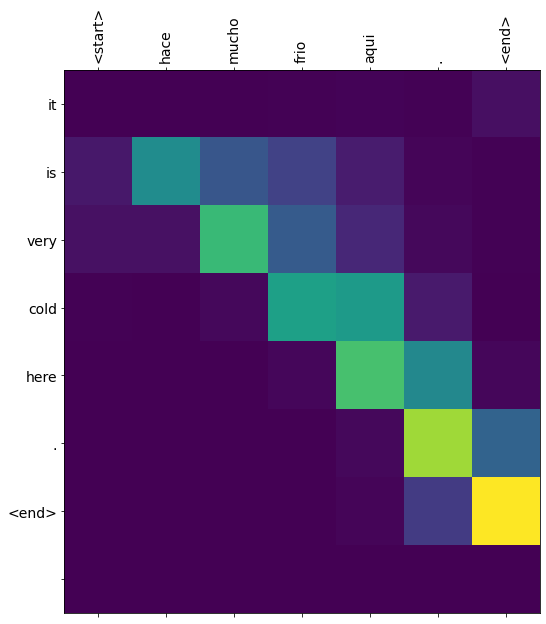

In [345]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


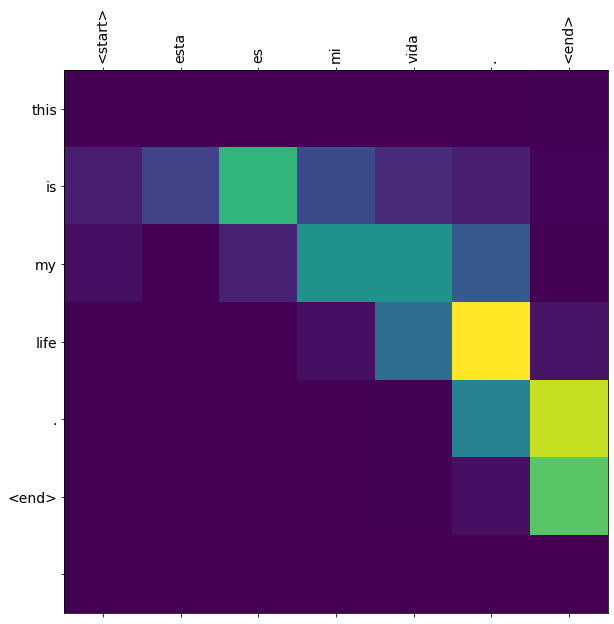

In [346]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still home ? <end> 


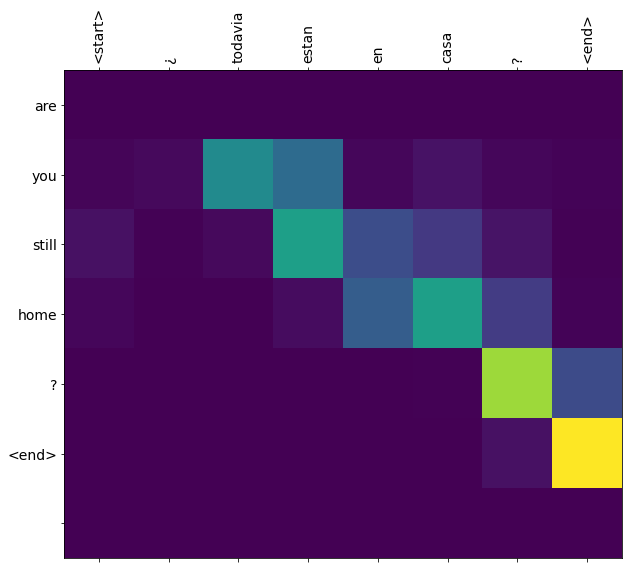

In [347]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


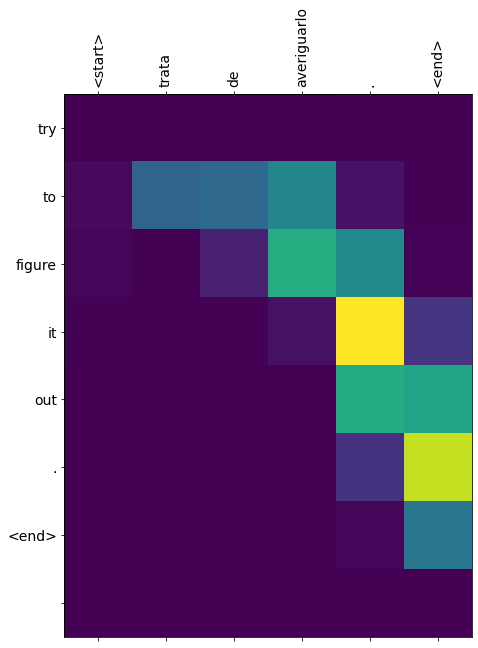

In [348]:
translate(u'trata de averiguarlo.')